# Deploying Predictive Systems

Building models that can make predictions was hard work. We had to extract the features of our training data from our raw data, vectorize those features, combine those vectors, create an experiment, and then train, test, and evaluate a statistical model. Fun stuff, but a lot of work!

At this point, it is important to understand that most predictions never make it out of the lab. This point is as far as they ever get. Nobody ever sees them on a website or even indirectly feels their output in any way. Most predictions die in the laboratory where they were created, and a big reason is that the people who build them don’t know how to deploy them. Deploying predictions is our topic in this chapter, and for the aforementioned reason it is an essential one for a practicing data scientist to master.

## Preparing for Predictions

One feature of our model is the distance between `Origin` and `Dest` airports. We need to create an API to get this distance for our web controller that will create predicton requests. This means we must define an API along with its data: `predict_utils.get_flight_distance`.

### Filling in the `predict_utils` API

This means we need a function in `predict_utils.py` called `get_flight_distance(origin, dest)` that returns the flight distance for each pair of airports. To implement this, let’s use PySpark to create a table in MongoDB containing the distance in miles keyed by the origin and destination airport codes. Check out [ch08/origin_dest_distances.py](origin_dest_distances.py). We run a simple `GROUP BY`/`AVG` query to compute the distances between airports:

In [6]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


In [8]:
import sys, os, re

# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")

origin_dest_distances = spark.sql("""
  SELECT Origin, Dest, AVG(Distance) AS Distance
  FROM on_time_performance
  GROUP BY Origin, Dest
  ORDER BY Distance
""")
origin_dest_distances.repartition(1).write.mode("overwrite").json("../data/origin_dest_distances.json")
os.system("cat ../data/origin_dest_distances.json/part* >> ../data/origin_dest_distances.jsonl")

0

And to load them into MongoDB we run an import of the resulting JSON Lines file. Check out [ch08/import_distances.sh](import_distances.sh), which also creates an index on the `Origin`/`Dest` key:

In [12]:
%%bash

# Import our enriched airline data as the 'airlines' collection
mongoimport -d agile_data_science -c origin_dest_distances --file ../data/origin_dest_distances.jsonl
mongo agile_data_science --quiet --eval 'db.origin_dest_distances.ensureIndex({Origin: 1, Dest: 1})'

{
	"createdCollectionAutomatically" : false,
	"numIndexesBefore" : 1,
	"numIndexesAfter" : 2,
	"ok" : 1
}


2018-05-03T12:30:29.978+0000	connected to: localhost
2018-05-03T12:30:30.203+0000	imported 4696 documents


Let’s verify our data is in Mongo:

In [13]:
%%bash

mongo agile_data_science --quiet --eval 'db.origin_dest_distances.find({"Origin": "ATL", "Dest": "JFK"})'

{ "_id" : ObjectId("5aeb00e6c11f972f229bd60e"), "Origin" : "ATL", "Dest" : "JFK", "Distance" : 760 }


Finally, in [ch08/web/predict_utils.py](web/predict_utils.py), we turn this into an API, `predict_utils.get_flight_distance`, that uses PyMongo:

```python
def get_flight_distance(client, origin, dest):
  """Get the distance between a pair of airport codes"""
  record = client.agile_data_science.origin_dest_distances.find_one({
    "Origin": origin,
    "Dest": dest,
  })
  return record["Distance"]
```

Now lets move on to deploying our prediction using Spark Streaming!

## Deploying Spark ML via Spark Streaming

With the rise of Apache Kafka, Spark Streaming has become an increasingly popular way of processing data in “near real time.” Our Spark Streaming workflow will reuse the code we created in the last section for training, storing, and loading the classifier model. But from there it will diverge, starting with how we create prediction requests.

In this case, our web application will emit a Kafka event when a prediction is needed, and after streaming through a Kafka cluster, it will arrive at a Spark Streaming process that will vectorize the features and make the prediction using the model it loads from disk. It will then write the result to a database, where the original web application will read and deliver the result.

Note that an important limitation to this method of deployment is that you can only use one model at a time. This can be a bottleneck for some applications, like making content-based recommendations in a recommender system, where one model is needed for each user, because you can’t loop through many models in one Spark Streaming process.

### Gathering Training Data in Production

We will reuse the code and Airflow configuration for gathering training data from the previous section on deploying a predictive system in batch. You can follow along with ch08/extract_features.py and refer back to “Gathering Training Data in Production”. Even in a Spark Streaming deployment, we still gather training data in production using PySpark in batch and Airflow.

### Training, Storing, and Loading Spark ML Models

Again, we will reuse the code and Airflow configuration for training and persisting our model from the previous section on deploying a predictive system in batch. You can follow along with ch08/train_spark_mllib_model.py and “Training, Storing, and Loading Spark ML Models”. Even in a Spark Streaming deployment, we still need Airflow to productionize the training and persistence of the model, which we will then deploy in Spark Streaming. Figure 8-7 illustrates our backend architecture.

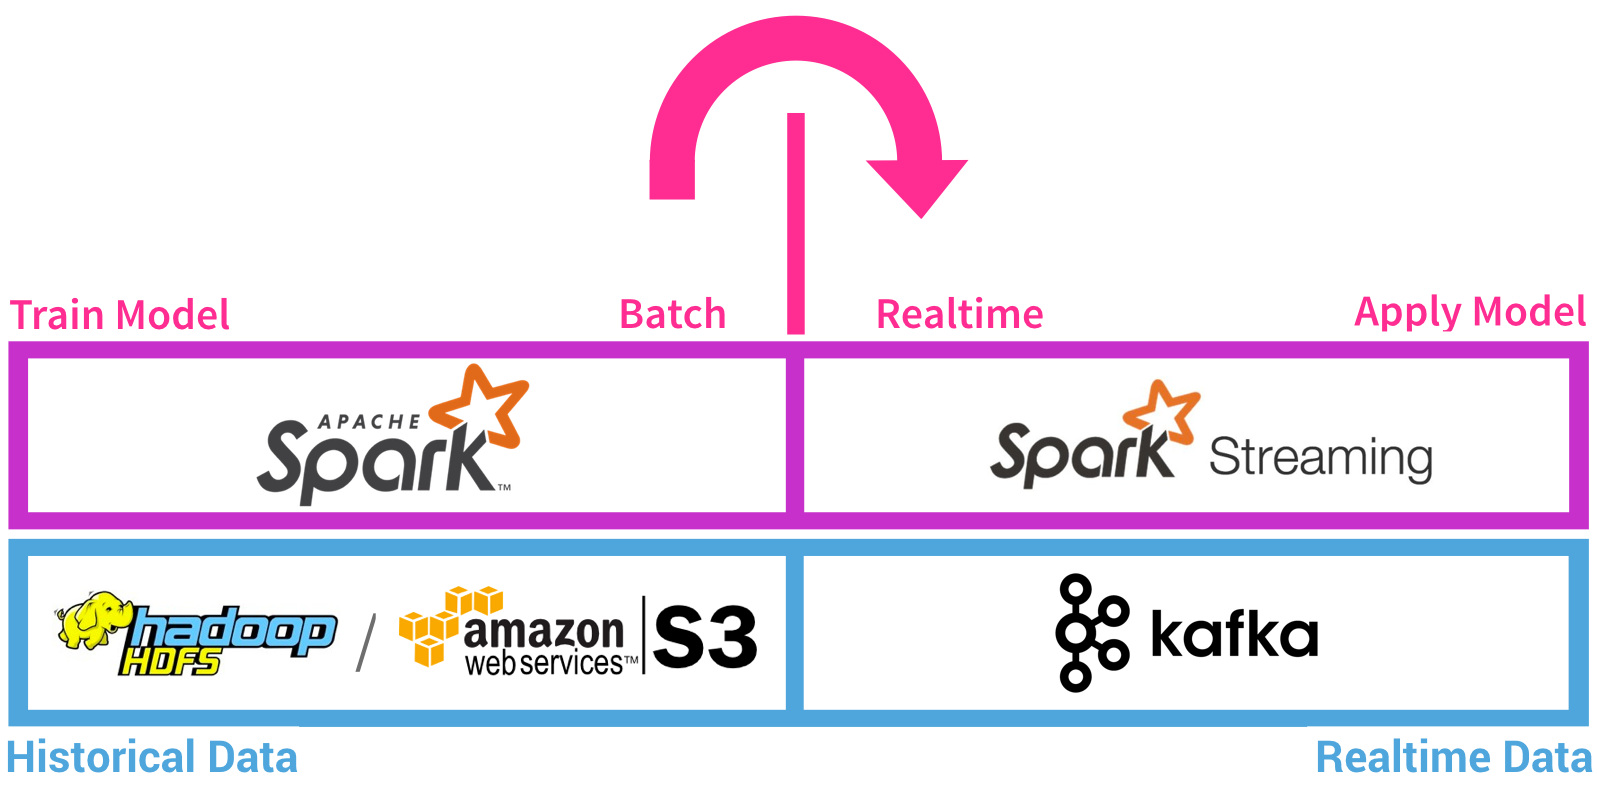

### Sending Prediction Requests to Kafka

In order to feed the prediction task and associated data to a Spark ML script deployed in batch, we need to generate Kafka events that indicate a prediction is needed. Our web application can easily do so using a form and an associated form controller that generates a prediction request as a Kafka message.

This is in contrast to the scikit-learn deployment via a web API, where the result was directly computed inside the web application. In the real world, this might correspond to a wide variety of circumstances, because any computation that takes longer than a fraction of a second is best deployed via Kafka. Kafka workers are precisely the place you want to handle a spike in load that would produce latency—Kafka is designed to handle such variable loads, and web applications are not.

In this case, a web application will emit a request for a prediction as a message in a Kafka topic. Then, a Spark Streaming minibatch will fetch today’s prediction requests and feed them to PySpark ML, which will create the predictions and store the results in a MongoDB collection. The prediction request page will then display the result of that prediction request’s prediction.

#### Setting up Kafka

Before proceeding, we’ll need to set up Kafka as we did in Chapter 2. You may want to refer to “Distributed Streams with Apache Kafka” to refresh yourself on Kafka, as this section is largely a rehash of that section. If you’ve already completed some of these steps and haven’t restarted your computer, you may be able to skip those steps you have already completed.

##### Create a Topic

Open another new console. We’ll use this one to run different Kafka commands, and then will leave it open as a console consumer for our prediction request topic.

Kafka messages are grouped into topics, so we need to create one before we can send messages through Kafka:

In [1]:
%%bash

../../kafka/bin/kafka-topics.sh \
    --create \
    --zookeeper localhost:2181 \
    --replication-factor 1 \
    --partitions 1 \
    --topic flight_delay_classification_request

Created topic "flight_delay_classification_request".


##### Verify our new prediction request topic

We can see the topic we created with the list topics command:

In [2]:
%%bash

../../kafka/bin/kafka-topics.sh --list --zookeeper localhost:2181

flight_delay_classification_request


We need to monitor this topic, so let’s run the console consumer on `flight_delay_classification_request` using a Terminal. Open a Terminal now and run:

```bash
cd
kafka/bin/kafka-console-consumer.sh \
    --bootstrap-server localhost:9092 \
    --topic flight_delay_classification_request \
    --from-beginning
```

That’s it. Now Kafka is ready to send and receive prediction requests, and we will see them as they occur! Now let’s set up our web application to emit requests.

### Feeding Kafka Recommendation Tasks from a Flask API

We will turn to kafka-python to act as Producer and emit Kafka events from our web application in [ch08/web/flask_predict.py](web/flask_predict.py).

First we need to import kafka-python and set up our KafkaProducer object, which will emit our events. We do so up top in our script, in case another controller needs Kafka. We also import the Python package uuid, which will create a unique ID for our prediction requests:

In [3]:
# Set up Kafka
from kafka import KafkaProducer, TopicPartition
producer = KafkaProducer(bootstrap_servers=['localhost:9092'],api_version=(0,10))
PREDICTION_TOPIC = 'flight_delay_classification_request'

import uuid

Next, we create a new API for prediction requests, based on the one we created for our batch requests, with a couple of changes. Instead of inserting requests into Mongo, we will emit JSON requests to our Kafka topic. These requests will each feature a Universally Unique Identifier (UUID) to identify them—a UUID is a random string long enough that it is very unlikely any other such string will overlap this one:

```python
# Make our API a post, so a search engine won't hit it
@app.route("/flights/delays/predict/classify_realtime", methods=['POST'])
def classify_flight_delays_realtime():
  
  # Define the form fields to process
  """POST API for classifying flight delays"""
  api_field_type_map = \
    {
      "DepDelay": float,
      "Carrier": str,
      "FlightDate": str,
      "Dest": str,
      "FlightNum": str,
      "Origin": str
    }
  
  # Fetch the values for each field from the form object
  api_form_values = {}
  for api_field_name, api_field_type in api_field_type_map.items():
    api_form_values[api_field_name] = request.form.get(
      api_field_name, type=api_field_type
    )
  
  # Set the direct values, which excludes Date
  prediction_features = {}
  for key, value in api_form_values.items():
    prediction_features[key] = value
  
  # Set the derived values
  prediction_features['Distance'] = predict_utils.get_flight_distance(
    client, api_form_values['Origin'],
    api_form_values['Dest']
  )
  
  # Turn the date into DayOfYear, DayOfMonth, DayOfWeek
  date_features_dict = predict_utils.get_regression_date_args(
    api_form_values['FlightDate']
  )
  for api_field_name, api_field_value in date_features_dict.items():
    prediction_features[api_field_name] = api_field_value
  
  # Add a timestamp
  prediction_features['Timestamp'] = predict_utils.get_current_timestamp()

  # Create a unique ID for this message
  unique_id = str(uuid.uuid4())
  prediction_features['UUID'] = unique_id
  
  message_bytes = json.dumps(prediction_features).encode()
  producer.send(PREDICTION_TOPIC, message_bytes)

  response = {"status": "OK", "id": unique_id}
  return json_util.dumps(response)
```

#### Running Our Prediction API

Now change directory to `ch08/web` and run the `predict_flask.py` script:

```bash
cd ch08/web
python ./predict_flask.py
```

We can test this API with curl and then by monitoring the console consumer we set up in the last section:

```bash
curl -XPOST 'http://localhost:5000/flights/delays/predict/classify_realtime' \
    -F 'DepDelay=5.0' \
    -F 'Carrier=AA' \
    -F 'FlightDate=2016-12-23' \
    -F 'Dest=ATL' \
    -F 'FlightNum=1519' \
    -F 'Origin=SFO' | json_pp
```

